# Model training and prediction - `composite`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [24]:
X_train = pd.read_csv("./data/processed/composite/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/composite/y_train.csv", index_col = 0).composite
X_test = pd.read_csv("./data/processed/composite/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/composite/y_test.csv", index_col = 0).composite
tc_train = pd.read_csv("./data/processed/composite/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/composite/tc_test.csv", index_col = 0).tc

In [25]:
y_train.value_counts() / len(y_train.index) * 100

0    97.914987
1     2.085013
Name: composite, dtype: float64

In [26]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [27]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [28]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.05), r=3)]

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Filter out warnings produced by R

In [30]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [71]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[200:205]
}

In [72]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [73]:
lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lgbm,
    # lr,
    rf
]

In [74]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [75]:
from src.models.classifiers import StackedGeneralizationClassifier

In [76]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [77]:
y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)

In [78]:
from sklearn.metrics import roc_auc_score

In [79]:
auc_test_con = roc_auc_score(y_score = y_test_prob_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.6997471183251001'

In [80]:
auc_test_cut = roc_auc_score(y_score = y_test_prob_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.5'

In [81]:
from src.visualization.visualize import (
    plot_roc, 
    plot_precision_recall,
    plot_triage_comparison
)

In [82]:
y_test_prob_cut

array([0., 0., 0., ..., 0., 0., 0.])

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/geoms/geom_rect.py:62: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/geoms/geom_rect.py:62: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 5 rows

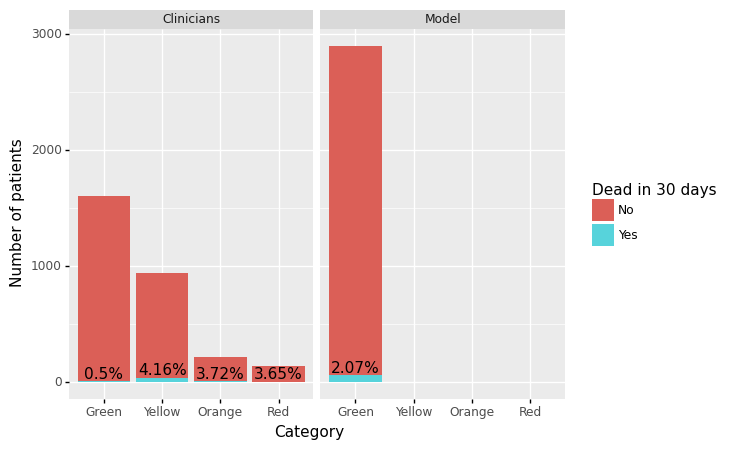

<ggplot: (683719218)>

In [83]:
plot_triage_comparison(y_test.astype(float), y_test_prob_cut.astype(float), tc_test)

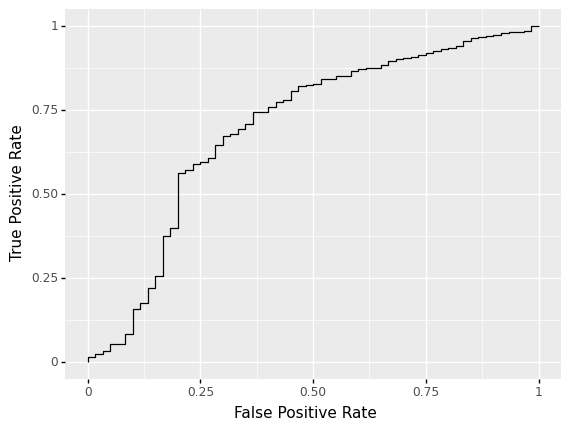

<ggplot: (276578115)>

In [84]:
plot_roc(y_test, y_test_prob_con)

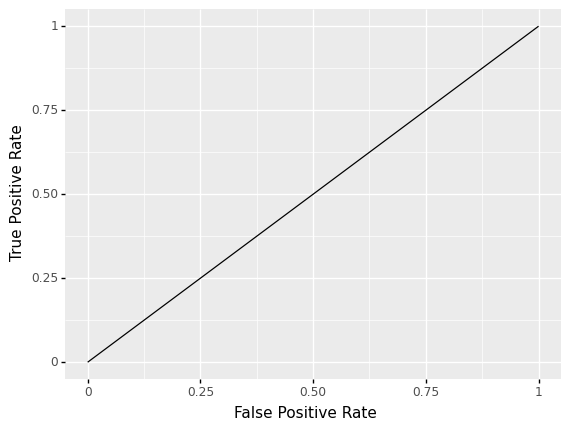

<ggplot: (683860575)>

In [85]:
plot_roc(y_test, y_test_prob_cut)

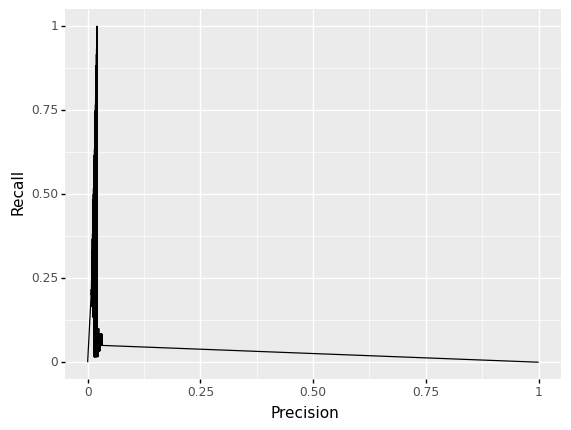

<ggplot: (683869206)>

In [86]:
plot_precision_recall(y_test, y_test_prob_con)

Plot roc curves for each classifier

In [87]:
from src.visualization.visualize import plot_roc_base_clfs

In [88]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [89]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [90]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [91]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [92]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_prob_con))

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


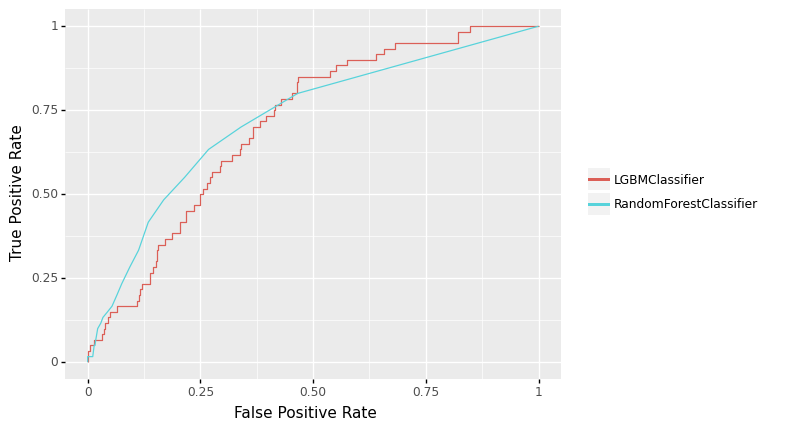

<ggplot: (683967425)>

In [93]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [94]:
from src.models.metrics import bootstrap, compute_performance

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [95]:
stats = bootstrap(
    X=X_train,
    y=y_train, 
    tc=tc_train,
    keys=keys + [sgclf.__class__.__name__],
    base_clfs=base_clfs,
    meta_clf=LogisticRegression(),
    all_hyper_parameters=all_hyper_parameters
)

  0%|                                                                          | 0/5 [00:00<?, ?it/s]During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-de

  0%|          | 0/20 [00:00<?, ?it/s]
                  Estimate
NRI           -0.114663740
NRI+          -0.238095238
NRI-           0.123431498
Pr(Up|Case)    0.000000000
Pr(Down|Case)  0.238095238
Pr(Down|Ctrl)  0.125480154
Pr(Up|Ctrl)    0.002048656
  0%|          | 0/20 [00:00<?, ?it/s]
                   Estimate
NRI           -0.1327389146
NRI+          -0.2531645570
NRI-           0.1204256424
Pr(Up|Case)    0.0000000000
Pr(Down|Case)  0.2531645570
Pr(Down|Ctrl)  0.1212042564
Pr(Up|Ctrl)    0.0007786141


/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

  0%|          | 0/20 [00:00<?, ?it/s]
                Estimate
NRI           -0.1395203
NRI+          -0.2564103
NRI-           0.1168899
Pr(Up|Case)    0.0000000
Pr(Down|Case)  0.2564103
Pr(Down|Ctrl)  0.1168899
Pr(Up|Ctrl)    0.0000000
  0%|          | 0/20 [00:00<?, ?it/s]
                   Estimate
NRI           -0.0888483294
NRI+          -0.2125000000
NRI-           0.1236516706
Pr(Up|Case)    0.0125000000
Pr(Down|Case)  0.2250000000
Pr(Down|Ctrl)  0.1241778479
Pr(Up|Ctrl)    0.0005261773
  0%|          | 0/20 [00:00<?, ?it/s]
                  Estimate
NRI           -0.208244141
NRI+          -0.328947368
NRI-           0.120703227
Pr(Up|Case)    0.000000000
Pr(Down|Case)  0.328947368
Pr(Down|Ctrl)  0.121490422
Pr(Up|Ctrl)    0.000787195


/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



In [96]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set list for simplifying compiling point estimates
y_test_prob_cuts = [None] * len(keys) + [y_test_prob_cut]
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(
        y_prob=prob, 
        y_pred=pred, 
        y_true=y_test, 
        y_pred_cut=cut, 
        tc=tc_test
    )
    for prob, pred, cut, k in zip(
        y_test_prob_clfs.T, 
        y_test_pred_clfs.T,
        y_test_prob_cuts,
        keys + [sgclf.__class__.__name__]
    )
}, orient = "index").stack().to_frame()
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = round(point_estimates - d1.to_frame(), 2)
lb = round(point_estimates - d2.to_frame(), 2)
# Compile performamance
perf_df = pd.concat([round(point_estimates, 2), lb, ub, ], axis = 1)

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI           -0.09704775
NRI+          -0.21666667
NRI-           0.11961891
Pr(Up|Case)    0.00000000
Pr(Down|Case)  0.21666667
Pr(Down|Ctrl)  0.11961891
Pr(Up|Ctrl)    0.00000000


In [97]:
point_estimates

0
LGBMClassifier                  roc_auc_con          0.708457
                                prec                 0.656463
                                rec                  0.507980
RandomForestClassifier          roc_auc_con          0.722010
                                prec                 0.989803
                                rec                  0.508333
StackedGeneralizationClassifier roc_auc_con          0.699747
                                prec                 0.489634
                                rec                  0.500000
                                roc_auc_cut          0.500000
                                roc_auc_model_model  0.199747
                                roc_auc_model_tc    -0.010733
                                nri                 -0.097048
                                nri_plus            -0.216667
                                nri_minus            0.119619

In [98]:
lb_str = lb.iloc[:, 0].astype(str) 
ub_str = ub.iloc[:, 0].astype(str)
pe_str = round(point_estimates, 2).iloc[:, 0].astype(str)
ci = pe_str + " (" + lb_str + " to " + ub_str +  ")"

In [99]:
perf_df = pd.concat([perf_df, ci.to_frame()], axis = 1)
perf_df.columns = ["point_estimate", "lb", "ub", "ci"]

In [100]:
perf_df

point_estimate    lb  \
LGBMClassifier                  roc_auc_con                    0.71  0.73   
                                prec                           0.66  0.74   
                                rec                            0.51  0.51   
RandomForestClassifier          roc_auc_con                    0.72  0.72   
                                prec                           0.99  1.49   
                                rec                            0.51  0.52   
StackedGeneralizationClassifier roc_auc_con                    0.70  0.66   
                                prec                           0.49  0.49   
                                rec                            0.50  0.50   
                                roc_auc_cut                    0.50  0.49   
                                roc_auc_model_model            0.20  0.17   
                                roc_auc_model_tc              -0.01 -0.09   
                                nri                           -0.10 -0.09   
                                nri_plus                      -0.22 -0.21   
                                nri_minus                      0.12  0.12   

                                                       ub  \
LGBMClassifier                  roc_auc_con          0.77   
                                prec                 0.82   
                                rec                  0.52   
RandomForestClassifier          roc_auc_con          0.79   
                                prec                 1.49   
                                rec                  0.52   
StackedGeneralizationClassifier roc_auc_con          0.71   
                                prec                 0.49   
                                rec                  0.50   
                                roc_auc_cut          0.50   
                                roc_auc_model_model  0.22   
                                roc_auc_model_tc    -0.02   
                                nri                 -0.01   
                                nri_plus            -0.13   
                                nri_minus            0.12   

                                                                         ci  
LGBMClassifier                  roc_auc_con             0.71 (0.73 to 0.77)  
                                prec                    0.66 (0.74 to 0.82)  
                                rec                     0.51 (0.51 to 0.52)  
RandomForestClassifier          roc_auc_con             0.72 (0.72 to 0.79)  
                                prec                    0.99 (1.49 to 1.49)  
                                rec                     0.51 (0.52 to 0.52)  
StackedGeneralizationClassifier roc_auc_con              0.7 (0.66 to 0.71)  
                                prec                    0.49 (0.49 to 0.49)  
                                rec                        0.5 (0.5 to 0.5)  
                                roc_auc_cut               0.5 (0.49 to 0.5)  
                                roc_auc_model_model      0.2 (0.17 to 0.22)  
                                roc_auc_model_tc     -0.01 (-0.09 to -0.02)  
                                nri                   -0.1 (-0.09 to -0.01)  
                                nri_plus             -0.22 (-0.21 to -0.13)  
                                nri_minus               0.12 (0.12 to 0.12)